In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 5)

In [2]:
def my_batch_generator(X, y, shuffle=True, batch_size=1):
    """
    Генератор новых батчей для обучения
    X          - матрица объекты-признаки
    y_batch    - вектор ответов
    shuffle    - нужно ли случайно перемешивать выборку
    batch_size - размер батча ( 1 это SGD, > 1 mini-batch GD)
    Генерирует подвыборку для итерации спуска (X_batch, y_batch)
    """

    data = np.hstack(
        (np.ones(y.shape[0]).reshape(-1, 1), np.hstack((X, y.reshape(-1, 1)))))
    if shuffle == True:
        np.random.shuffle((data))
    current_row = 0
    X_batch = np.array([])
    y_batch = np.array([])
    while 1:
        if current_row >= X.shape[0]:
            break
        X_batch = data[current_row:current_row + batch_size, :-1]
        y_batch = data[current_row:current_row + batch_size, -1:-2:-1]
        current_row += batch_size
        yield (X_batch, y_batch)

# Теперь можно сделать генератор по данным ()
#  my_batch_generator = batch_generator(X, y, shuffle=True, batch_size=1):

In [3]:
# %%pycodestyle

from sklearn.base import BaseEstimator, ClassifierMixin


def sigmoid(x):
    """
    Вычисляем значение сигмоида.
    X - выход линейной модели
    """

    sigm_value_x = 1 / (1 + np.exp(-x)).ravel()
    return sigm_value_x


class MySGDClassifier(BaseEstimator, ClassifierMixin):

    def __init__(self, batch_generator, C=1, alpha=0.01, max_epoch=10, model_type='lin_reg', regular=True, product=False, border=0.5):
        """
        batch_generator -- функция генератор, которой будем создавать батчи
        C - коэф. регуляризации
        alpha - скорость спуска
        max_epoch - максимальное количество эпох
        model_type - тим модели, lin_reg или log_reg
        """

        self.C = C
        self.alpha = alpha
        self.max_epoch = max_epoch
        self.batch_generator = batch_generator
        self.errors_log = {'iter': [], 'loss': []}
        self.model_type = model_type
        self.regular = regular
        self.product = product
        self.border = border

    def calc_loss(self, X_batch, y_batch):
        """
        Считаем функцию потерь по батчу 
        X_batch - матрица объекты-признаки по батчу
        y_batch - вектор ответов по батчу
        Не забудте тип модели (линейная или логистическая регрессия)!
        """
        if self.model_type == 'lin_reg':
            loss = ((X_batch @ self.weights.reshape(-1, 1) - y_batch).T @
                    (X_batch @ self.weights.reshape(-1, 1) - y_batch)).ravel() / y_batch.shape[0]

        elif self.model_type == 'log_reg':
            loss = -(np.log(sigmoid(X_batch @ self.weights.reshape(-1, 1))).T @ y_batch +
                     np.log(1 - sigmoid(X_batch @ self.weights.reshape(-1, 1))).T @ (1 - y_batch)) / \
                y_batch.shape[0]

        return loss

    def calc_loss_grad(self, X_batch, y_batch):
        """
        Считаем  градиент функции потерь по батчу (то что Вы вывели в задании 1)
        X_batch - матрица объекты-признаки по батчу
        y_batch - вектор ответов по батчу
        Не забудте тип модели (линейная или логистическая регрессия)!
        """
        if self.model_type == 'lin_reg':
            loss_grad = (2 * (X_batch @ self.weights.reshape(-1, 1) - y_batch.reshape(-1, 1)).T @ X_batch
                         / y_batch.shape[0]).ravel()

        elif self.model_type == 'log_reg':
            loss_grad = ((sigmoid(X_batch @ self.weights.reshape(-1, 1)).reshape(-1, 1) - y_batch).T @
                         X_batch).ravel() / X_batch.shape[0]

        if self.regular:
            loss_grad += 2 * self.weights / self.C
            loss_grad[0] -= 2 * self.weights[0] / self.C

        return loss_grad

    def update_weights(self, new_grad):
        """
        Обновляем вектор весов
        new_grad - градиент по батчу
        """
        self.weights = self.weights - self.alpha * new_grad

    def fit(self, X, y, border=0.5):
        '''
        Обучение модели
        X - матрица объекты-признаки
        y - вектор ответов
        '''

        # Нужно инициализровать случайно веса
        self.weights = np.ones(X.shape[1] + 1)
        for n in range(0, self.max_epoch):
            new_epoch_generator = self.batch_generator(
                X, y, shuffle=True, batch_size=1)
            for batch_num, new_batch in enumerate(new_epoch_generator):
                X_batch = new_batch[0]
                y_batch = new_batch[1]
                batch_grad = self.calc_loss_grad(X_batch, y_batch)
                self.update_weights(batch_grad)
                # Подумайте в каком месте стоит посчитать ошибку для отладки модели
                # До градиентного шага или после
                if self.product == False:
                    batch_loss = self.calc_loss(X_batch, y_batch)
                    self.errors_log['loss'].append(batch_loss)
                self.errors_log['iter'].append(batch_num)
        return self

    def predict(self, X):
        '''
        Предсказание класса
        X - матрица объекты-признаки
        Не забудте тип модели (линейная или логистическая регрессия)!
        '''
        if self.model_type == 'lin_reg':
            X_ = np.hstack((np.ones(X.shape[0]).reshape(-1, 1), X))
            y_hat = ((np.sign((X_ @ self.weights.reshape(-1, 1))) + 1) / 2).ravel()

        elif self.model_type == 'log_reg':
            X_ = np.hstack((np.ones(X.shape[0]).reshape(-1, 1), X))
            y_hat = np.where(
                sigmoid(X_ @ self.weights.reshape(-1, 1)) > self.border, 1, 0)

        # Желательно здесь использовать матричные операции между X и весами, например, numpy.dot
        return y_hat

Запустите обе регрессии на синтетических данных. 


Выведите полученные веса и нарисуйте разделяющую границу между классами (используйте только первых два веса для первых двух признаков X[:,0], X[:,1] для отображения в 2d пространство ).  

In [8]:
def plot_decision_boundary(clf):
    # Your code Here
    # Значение-разделитель: если a(x, w) > y_sep, то y = 1, иначе - 0. Здесь - ср.арифм. таргетов
    y_sep = 0.5
    x1_cor = [-5, 10]
    x2_cor = [-(clf.weights[1] / clf.weights[2]) * x1_cor[0] + (y_sep - clf.weights[0]) / clf.weights[2],
              -(clf.weights[1] / clf.weights[2]) * x1_cor[1] + (y_sep - clf.weights[0]) / clf.weights[2]]
    plt.plot(x1_cor, x2_cor, label=clf.model_type)
    # Примечание: в данной реализации нулевой признак - фиктивный.
    # Поэтому график зависимости строится по 1-ому и 2-ому признаку, и имеет вид:
    # x2 = ax1 + b, где a = -(w1/w2), b = (y_sep - w0) / w2

[ 0.05428192  0.10348997 -0.08161589]
0.09977640791066518
[-7.80375849  1.60708436 -1.88861537]
0.28158232609915146


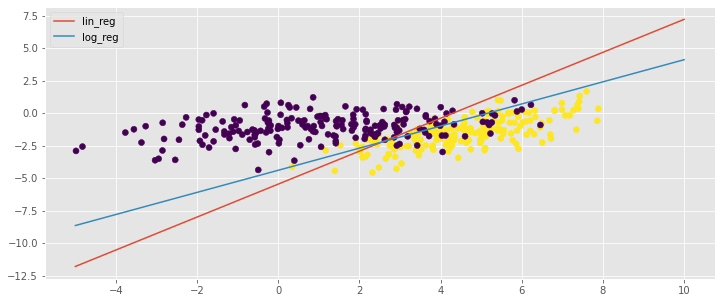

In [9]:
np.random.seed(0)

C1 = np.array([[0., -0.8], [1.5, 0.8]])
C2 = np.array([[1., -0.7], [2., 0.7]])
gauss1 = np.dot(np.random.randn(200, 2) + np.array([5, 3]), C1)
gauss2 = np.dot(np.random.randn(200, 2) + np.array([1.5, 0]), C2)

X = np.vstack([gauss1, gauss2])
y = np.r_[np.ones(200), np.zeros(200)]

lin_sgd_classifier = MySGDClassifier(
    my_batch_generator, C=1, alpha=0.003, max_epoch=1000, model_type='lin_reg', regular=True)
lin_sgd_classifier = lin_sgd_classifier.fit(X, y)
plot_decision_boundary(lin_sgd_classifier)
print(lin_sgd_classifier.weights)
print(np.array(lin_sgd_classifier.errors_log['loss']).mean())
log_sgd_classifier = MySGDClassifier(
    my_batch_generator, C=1, alpha=0.003, max_epoch=1000, model_type='log_reg', regular=False)
log_sgd_classifier = log_sgd_classifier.fit(X, y)
print(log_sgd_classifier.weights)
print(np.array(log_sgd_classifier.errors_log['loss']).mean())
plot_decision_boundary(log_sgd_classifier)
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.legend()

Далее будем анализировать Ваш алгоритм. 
Для этих заданий используйте датасет ниже.

In [4]:
from sklearn.datasets import make_classification

In [5]:
X, y = make_classification(n_samples=100000, n_features=10,
                           n_informative=4, n_redundant=0,
                           random_state=123, class_sep=1.0,
                           n_clusters_per_class=1)

Покажите сходимости обеих регрессией на этом датасете: изобразите график  функции потерь, усредненной по $N$ шагам градиентого спуска, для разных `alpha` (размеров шага). Разные `alpha` расположите на одном графике. 

$N$ можно брать 10, 50, 100 и т.д. 

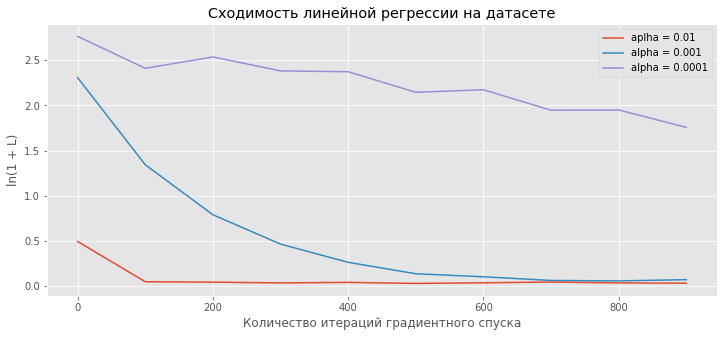

In [12]:
# Your Code Here
# Здесь построение графиков для линейной регрессии.
N = 100
sgd_classifier = MySGDClassifier(
    my_batch_generator, C=1, alpha=0.01, max_epoch=10, model_type='lin_reg', regular=True)
sgd_classifier = sgd_classifier.fit(X, y)
avg_losses_1 = np.log(np.array(
    sgd_classifier.errors_log['loss']).reshape(-1, N).mean(axis=1) + 1).ravel()[:10]
sgd_classifier = MySGDClassifier(
    my_batch_generator, C=1, alpha=0.001, max_epoch=10, model_type='lin_reg', regular=True)
sgd_classifier = sgd_classifier.fit(X, y)
avg_losses_2 = np.log(np.array(
    sgd_classifier.errors_log['loss']).reshape(-1, N).mean(axis=1) + 1).ravel()[:10]
sgd_classifier = MySGDClassifier(
    my_batch_generator, C=1, alpha=0.0001, max_epoch=10, model_type='lin_reg', regular=True)
sgd_classifier = sgd_classifier.fit(X, y)
avg_losses_3 = np.log(np.array(
    sgd_classifier.errors_log['loss']).reshape(-1, N).mean(axis=1) + 1).ravel()[:10]
plt.plot(N * np.arange(avg_losses_1.shape[0]),
         avg_losses_1, label='aplha = 0.01')
plt.plot(N * np.arange(avg_losses_2.shape[0]),
         avg_losses_2, label='alpha = 0.001')
plt.plot(N * np.arange(avg_losses_3.shape[0]),
         avg_losses_3, label='alpha = 0.0001')
plt.xlabel('Количество итераций градиентного спуска')
plt.ylabel('ln(1 + L)')
plt.title('Сходимость линейной регрессии на датасете')
plt.legend()

Text(0.5, 1.0, 'Сходимость линейной регрессии на датасете(maniac version)')

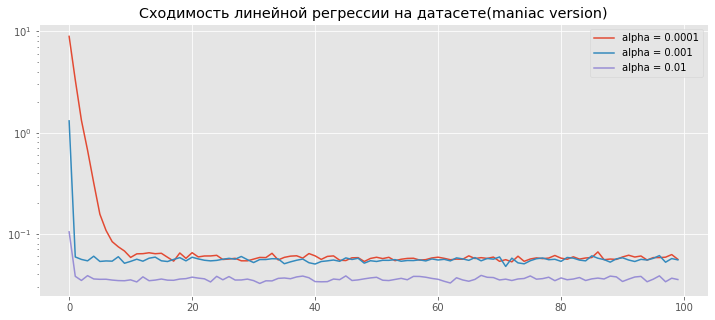

In [11]:
alphas = [0.0001, 0.001, 0.01]
my_cls_lin = [MySGDClassifier(my_batch_generator, max_epoch=1, alpha=x,
                              C=1,  model_type='lin_reg', regular=True) for x in alphas]
N = 1000
fig = plt.figure()

ax = fig.add_subplot(111)
ax.set_yscale('log')

for i in range(len(alphas)):
    my_cls_lin[i].fit(X, y)
    loss = np.array(my_cls_lin[i].errors_log['loss']
                    ).reshape(-1, N).mean(axis=1)[:]
    ax.plot(np.arange(loss.shape[0]), loss, label='alpha = '+str(alphas[i]))
ax.legend()
plt.title('Сходимость линейной регрессии на датасете(maniac version)')

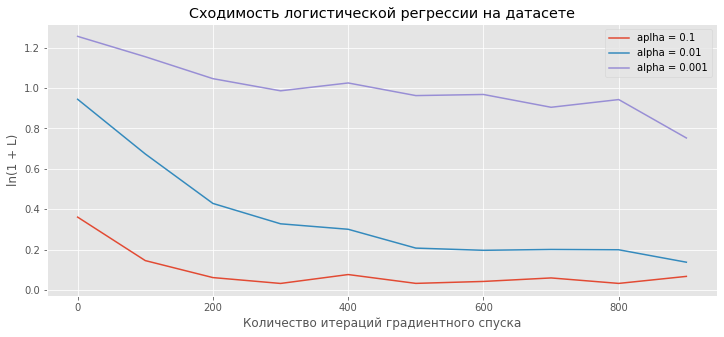

In [13]:
# Здесь построение графиков для логистической регрессии.
N = 100
sgd_classifier = MySGDClassifier(
    my_batch_generator, C=1, alpha=0.1, max_epoch=10, model_type='log_reg', regular=False)
sgd_classifier = sgd_classifier.fit(X, y)
avg_losses_1 = np.log(np.array(
    sgd_classifier.errors_log['loss']).reshape(-1, N).mean(axis=1) + 1).ravel()[:10]
sgd_classifier = MySGDClassifier(
    my_batch_generator, C=1, alpha=0.01, max_epoch=10, model_type='log_reg', regular=False)
sgd_classifier = sgd_classifier.fit(X, y)
avg_losses_2 = np.log(np.array(
    sgd_classifier.errors_log['loss']).reshape(-1, N).mean(axis=1) + 1).ravel()[:10]
sgd_classifier = MySGDClassifier(
    my_batch_generator, C=1, alpha=0.001, max_epoch=10, model_type='log_reg', regular=False)
sgd_classifier = sgd_classifier.fit(X, y)
avg_losses_3 = np.log(np.array(
    sgd_classifier.errors_log['loss']).reshape(-1, N).mean(axis=1) + 1).ravel()[:10]
plt.plot(N * np.arange(avg_losses_1.shape[0]),
         avg_losses_1, label='aplha = 0.1')
plt.plot(N * np.arange(avg_losses_2.shape[0]),
         avg_losses_2, label='alpha = 0.01')
plt.plot(N * np.arange(avg_losses_3.shape[0]),
         avg_losses_3, label='alpha = 0.001')
plt.xlabel('Количество итераций градиентного спуска')
plt.ylabel('ln(1 + L)')
plt.title('Сходимость логистической регрессии на датасете')
plt.legend()

Text(0.5, 1.0, 'Сходимость логистической регрессии на датасете(maniac version)')

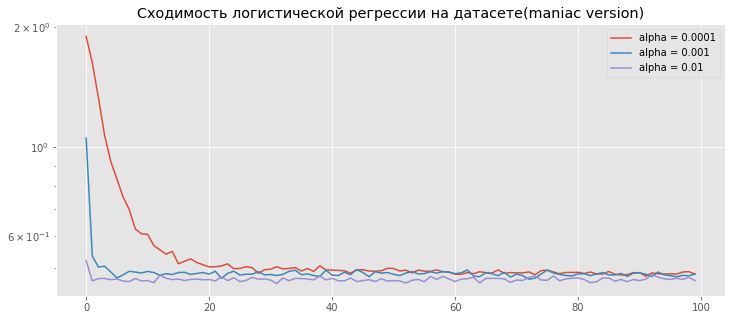

In [12]:
alphas = [0.0001, 0.001, 0.01]
my_cls_log = [MySGDClassifier(my_batch_generator, max_epoch=1, alpha=x,
                              C=1,  model_type='log_reg', regular=True) for x in alphas]
N = 1000
fig = plt.figure()

ax = fig.add_subplot(111)
ax.set_yscale('log')

for i in range(len(alphas)):
    my_cls_log[i].fit(X, y)
    loss = np.array(my_cls_log[i].errors_log['loss']
                    ).reshape(-1, N).mean(axis=1)[:]
    ax.plot(np.arange(loss.shape[0]), loss, label='alpha = '+str(alphas[i]))
ax.legend()
plt.title('Сходимость логистической регрессии на датасете(maniac version)')

Что Вы можете сказать про сходимость метода при различных `alpha`? Какое значение стоит выбирать для лучшей сходимости?

Изобразите график среднего значения весов для обеих регрессий в зависимости от коеф. регуляризации С из `np.logspace(3, -3, 10)` 

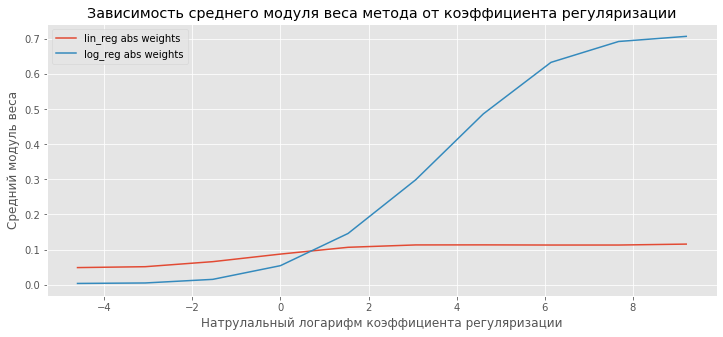

In [14]:
# Your Code Here
C_array = np.logspace(4, -2, 10)
lin_weights = []
log_weights = []
for C_ in C_array:
    lin_clf = MySGDClassifier(my_batch_generator, C=C_, alpha=0.001,
                              max_epoch=1, model_type='lin_reg', regular=True)
    log_clf = MySGDClassifier(my_batch_generator, C=C_, alpha=0.001,
                              max_epoch=1, model_type='log_reg', regular=True)
    lin_clf = lin_clf.fit(X, y)
    log_clf = log_clf.fit(X, y)
    lin_weights.append(np.abs(lin_clf.weights).mean())
    log_weights.append(np.abs(log_clf.weights).mean())
plt.plot(np.log(C_array), lin_weights, label='lin_reg abs weights')
plt.plot(np.log(C_array), log_weights, label='log_reg abs weights')
plt.xlabel('Натрулальный логарифм коэффициента регуляризации')
plt.ylabel('Средний модуль веса')
plt.title('Зависимость среднего модуля веса метода от коэффициента регуляризации')
plt.legend()

Довольны ли Вы, насколько сильно уменьшились Ваши веса? 

# Боевое применение (4  балла)

**Защита данной части возможна только при преодолении в проекте бейзлайна Handmade baseline.**

Давайте применим модель на итоговом проекте! Датасет сделаем точно таким же образом, как было показано в project_overview.ipynb

Применим обе регрессии, подберем для них параметры и сравним качество. Может быть Вы еще одновременно с решением домашней работы подрастете на лидерборде!

In [15]:
doc_to_title = {}
with open('docs_titles.tsv') as f:
    for num_line, line in enumerate(f):
        if num_line == 0:
            continue
        data = line.strip().split('\t', 1)
        doc_id = int(data[0])
        if len(data) == 1:
            title = ''
        else:
            title = data[1]
        doc_to_title[doc_id] = title
print(len(doc_to_title))

28026


In [16]:
import pandas as pd
train_data = pd.read_csv('train_groups.csv')
traingroups_titledata = {}
for i in range(len(train_data)):
    new_doc = train_data.iloc[i]
    doc_group = new_doc['group_id']
    doc_id = new_doc['doc_id']
    target = new_doc['target']
    title = doc_to_title[doc_id]
    if doc_group not in traingroups_titledata:
        traingroups_titledata[doc_group] = []
    traingroups_titledata[doc_group].append((doc_id, title, target))

In [17]:
import numpy as np
y_train = []
X_train = []
groups_train = []
for new_group in traingroups_titledata:
    docs = traingroups_titledata[new_group]
    for k, (doc_id, title, target_id) in enumerate(docs):
        y_train.append(target_id)
        groups_train.append(new_group)
        all_dist = []
        words = set(title.strip().split())
        for j in range(0, len(docs)):
            if k == j:
                continue
            doc_id_j, title_j, target_j = docs[j]
            words_j = set(title_j.strip().split())
            all_dist.append(len(words.intersection(words_j)))
        X_train.append(sorted(all_dist, reverse=True)[0:15])
X_train = np.array(X_train)
y_train = np.array(y_train)
groups_train = np.array(groups_train)
print(X_train.shape, y_train.shape, groups_train.shape)

(11690, 15) (11690,) (11690,)


Подберите размер батча для обучения. Линейная модель не должна учиться дольше нескольких минут. 

Не забывайте использовать скейлер!

In [18]:
from sklearn.metrics import f1_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

In [19]:
from sklearn.model_selection import cross_val_score

Разбейте данные на обучение и валидацию. Подберите параметры C, alpha, max_epoch, model_type на валидации (Вы же помните, как правильно в этой задаче делать валидацию?)

In [27]:
borders = (np.arange(50) + 1) / 50
max_score = 0
max_border = 0
clf = MySGDClassifier(my_batch_generator, C=10000, alpha=0.001,
                      max_epoch=100, model_type='log_reg', regular=True, product=True)
for border in borders:
    clf.border = border
    cur_score = cross_val_score(
        clf, X_train, y_train, cv=3, scoring='f1').mean()
    if cur_score > max_score:
        max_score = cur_score
        max_border = border
# Валидация проведена не совсем корректно: в данной задаче есть отдельное подразбиение на группы,
# документы в которых могут быть как-то связаны друг с другом (приводя аналогию с лекций: валидация
# производится по "дому", "цена некоторых квартир" в котором уже известна.
# Поскольку данная форма cross_val_score не гарантирует разбиение на данные в задании группы, то, вообще говоря,
# не факт, что модель проверяется на чём-то, не изученном ранее.
# Данная ошибка была обнаружена не сразу, а времени на повторную прогонку и кросс-валидацию с использованием
# group в cross_val_score, к сожалению, не было :(

In [29]:
print(max_border, max_score)

0.28 0.6146393523904768


Подберите порог линейной модели, по достижении которого, Вы будете относить объект к классу 1. Вспомните, какую метрику мы оптимизируем в соревновании.  Как тогда правильно подобрать порог?

In [30]:
clf.border = max_border
clf.fit(X_train, y_train)

MySGDClassifier(C=10000, alpha=0.001,
                batch_generator=<function my_batch_generator at 0x7fdd42066710>,
                border=0.28, max_epoch=100, model_type='log_reg', product=True)

С лучшими параметрами на валидации сделайте предсказание на тестовом множестве, отправьте его на проверку на платформу kaggle. Убедитесь, что Вы смогли побить public score первого бейзлайна.

** При сдаче домашки Вам необходимо кроме ссылки на ноутбук показать Ваш ник на kaggle, под которым Вы залили решение, которое побило Handmade baseline. **

In [37]:
test_data = pd.read_csv('test_groups.csv')
testgroups_titledata = {}
for i in range(len(test_data)):
    new_doc_test = test_data.iloc[i]
    doc_group_test = new_doc_test['group_id']
    doc_id_test = new_doc_test['doc_id']
    title_test = doc_to_title[doc_id_test]
    if doc_group_test not in testgroups_titledata:
        testgroups_titledata[doc_group_test] = []
    testgroups_titledata[doc_group_test].append((doc_id_test, title_test))

In [39]:
X_test = []
groups_test = []
for new_group in testgroups_titledata:
    docs_test = testgroups_titledata[new_group]
    for k, (doc_id_test, title_test) in enumerate(docs_test):
        groups_test.append(new_group)
        all_dist_test = []
        words_test = set(title_test.strip().split())
        for j in range(0, len(docs_test)):
            if k == j:
                continue
            doc_id_j_test, title_j_test = docs_test[j]
            words_j_test = set(title_j_test.strip().split())
            all_dist_test.append(len(words_test.intersection(words_j_test)))
        X_test.append(sorted(all_dist_test, reverse=True)[0:15])
X_test = np.array(X_test)
groups_test = np.array(groups_test)

In [40]:
df = pd.read_csv('test_groups.csv')
df = df.drop(['group_id', 'doc_id'], axis=1)
df['target'] = clf.predict(X_test)

In [42]:
df.to_csv('prediction.csv', index=False)